In [35]:
#Refer to https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
#Refer to: https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb
#Train and then validate and test the model

In [36]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.9.1


## Hyperparameters

In [37]:
batch_size = 32
seq_len = 43 # seq_len=43 意思是用43天的数据预测第44天后的趋势
column_len = 6 #the number of column
predict_column = 5 #which column to be predict, from 0 to column_len-1
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
epochs = 20
#
stock_id = '002824'
use_checkpoints_id = '399001' #None or else. use other's pre-train model instead of itself(None)
train_from_scratch = False  # True: Train the model, False: Use the pre-train checkpoints
stock_price_path = 'stockData/' + stock_id + '.csv'

In [38]:
#Load data from DB to csv file
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

query = "select date,open,high,low,close,Volume from qian_fuquan_stockprice where stockid='" + stock_id + "' order by date"

outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)

with open(stock_price_path, 'w') as f:
    cursor.copy_expert(outputquery, f)    

# Closing the connection
conn.close()

#Remove the first record, since it has big price change and will impact the AI
lines = []

with open(stock_price_path, 'r') as f:
    lines = f.readlines()

#Append the predict mock date price:     
latest_record = lines[len(lines)-1]
#Replace the latest record date to 9999-01-01 and append it to the last line of file
latest_record = '9999-01-01' + latest_record[10:]    
    
with open(stock_price_path, 'w') as f:
    f.writelines(lines[:1] + lines[2:] + list(latest_record)) 

## Load data

In [39]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

df.sort_values('date', inplace=True)
df.tail(50)

,date,open,high,low,close,volume,Max_Close_Price_In_Next_N_Days,Close_Price_After_N_Days,Max_Close_Diff,Close_Diff,Result
1483,2023-03-29,30.07,30.91,30.06,30.28,30862,31.43,26.68,1.15,-3.60,0
1484,2023-03-30,30.28,30.68,29.88,30.60,27693,31.43,26.51,0.83,-4.09,0
1485,2023-03-31,30.62,31.75,30.60,31.43,46700,31.43,26.51,0.00,-4.92,0
1486,2023-04-03,31.37,31.37,30.68,31.02,37274,31.02,26.07,0.00,-4.95,0
1487,2023-04-04,30.98,30.98,29.54,29.81,47306,30.43,26.77,0.62,-3.04,0
1488,2023-04-06,29.73,30.29,29.66,30.09,21800,30.43,26.70,0.34,-3.39,0
1489,2023-04-12,30.14,30.38,29.42,29.94,36225,30.43,26.33,0.49,-3.61,0
1490,2023-04-13,29.70,30.05,29.44,29.50,21540,30.43,26.76,0.93,-2.74,0
1491,2023-04-14,29.56,30.46,29.52,30.09,29845,30.43,26.38,0.34,-3.71,0
1492,2023-04-17,30.14,30.77,30.00,30.43,19280,30.43,26.53,0.00,-3.90,0


In [40]:
print('Drop temp column, do not use them for training and testing')
del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

df.tail()

Drop temp column, do not use them for training and testing


,date,open,high,low,close,volume,Result
1528,2023-06-09,28.37,28.77,28.07,28.45,32288,0
1529,2023-06-12,28.50,29.96,28.22,29.92,85452,0
1530,2023-06-13,29.54,30.78,29.33,29.63,77891,0
1531,2023-06-14,29.75,29.85,29.10,29.31,41765,0
1532,9999-01-01,29.75,29.85,29.10,29.31,41765,0


## Plot daily closing prices and volume

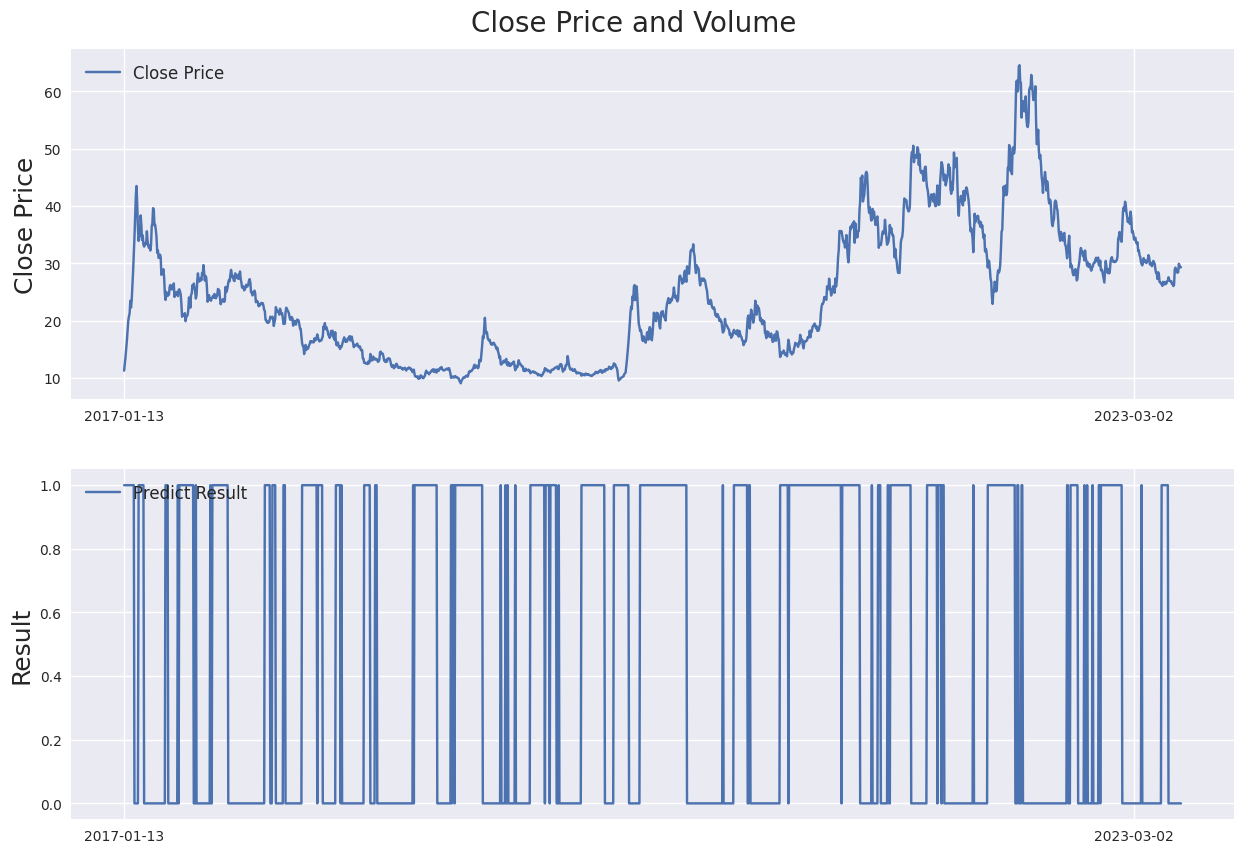

In [41]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Calculate normalized percentage change of all columns

In [42]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()
#df['Result'] = df['Result'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]

if train_from_scratch:
    #if train_from_scratch is True, then use the only last 10 pct for predict
    df_test = df[(df.index >= last_10pct)]
    df_test_with_date = df[(df.index >= last_10pct)]
else: 
    #if train_from_scratch is False, then I could like to use all the df data for predict
    df_test = df[(df.index >= 0)]
    df_test_with_date = df[(df.index >= 0)]

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail(50)

Training data shape: (1226, 6)
Validation data shape: (153, 6)
Test data shape: (1532, 6)


,open,high,low,close,volume,Result
1177,0.427610,0.372365,0.407933,0.412109,0.001724,1.0
1178,0.407363,0.506675,0.437298,0.510153,0.004743,1.0
1179,0.490854,0.518589,0.477861,0.516917,0.003690,0.0
1180,0.529406,0.415632,0.366533,0.250427,0.001735,1.0
1181,0.237452,0.227212,0.352829,0.381662,0.000891,1.0
1182,0.407966,0.389438,0.412133,0.419197,0.002109,1.0
1183,0.405612,0.627248,0.429542,0.647832,0.006294,1.0
1184,0.665450,0.531875,0.630628,0.491695,0.002811,1.0
1185,0.464526,0.472404,0.502346,0.499322,0.001633,0.0
1186,0.490853,0.436539,0.480521,0.390764,0.001204,1.0


## Plot daily changes of close prices and volume

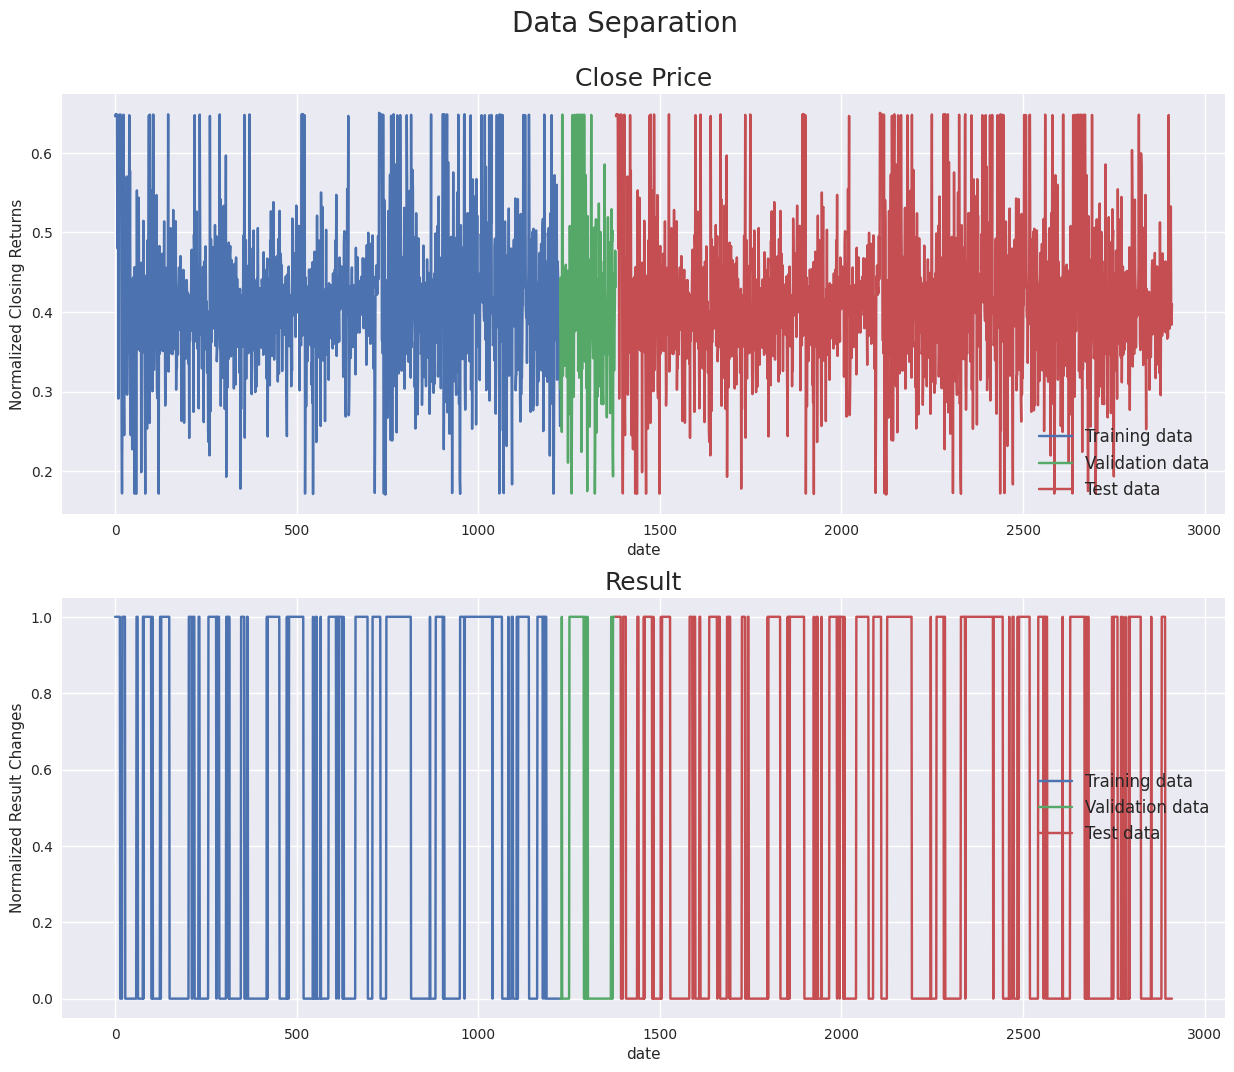

In [43]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Create chunks of training, validation and test data

In [44]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  #y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
  y_train.append(train_data[:, predict_column][i]) #Value of 6th column (Result) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)
#print(X_test.shape, y_test.shape)
#print(X_test_with_date_last_43.shape)
#print(X_test_with_date_last_43)

Training set shape (1183, 43, 6) (1183,)
Validation set shape (110, 43, 6) (110,)
Testing set shape (1489, 43, 6) (1489,)


## Model

In [45]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x) #predict the price
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape']) #linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

ckp = './checkpoints/Transformer+TimeEmbedding_' + stock_id + '.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(ckp, 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:    
    if use_checkpoints_id != None:
        ckp = './checkpoints/Transformer+TimeEmbedding_' + use_checkpoints_id + '.hdf5'
        
    model = tf.keras.models.load_model(ckp,
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''
df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values
df2_close_price = df2_close[-len(test_data):]

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Result')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Result')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_close_price, label='Result')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 43, 6)]      0           []                               
                                                                                                  
 time2_vector_5 (Time2Vector)   (None, 43, 2)        172         ['input_4[0][0]']                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 43, 8)        0           ['input_4[0][0]',                
                                                                  'time2_vector_5[0][0]']         
                                                                                                  
 transformer_encoder_15 (Transf  (None, 43, 8)       111920      ['concatenate_3[0][0]',    

OSError: No file or directory found at ./checkpoints/Transformer+TimeEmbedding_399001.hdf5

## Model metrics

In [46]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

## Model architecture overview

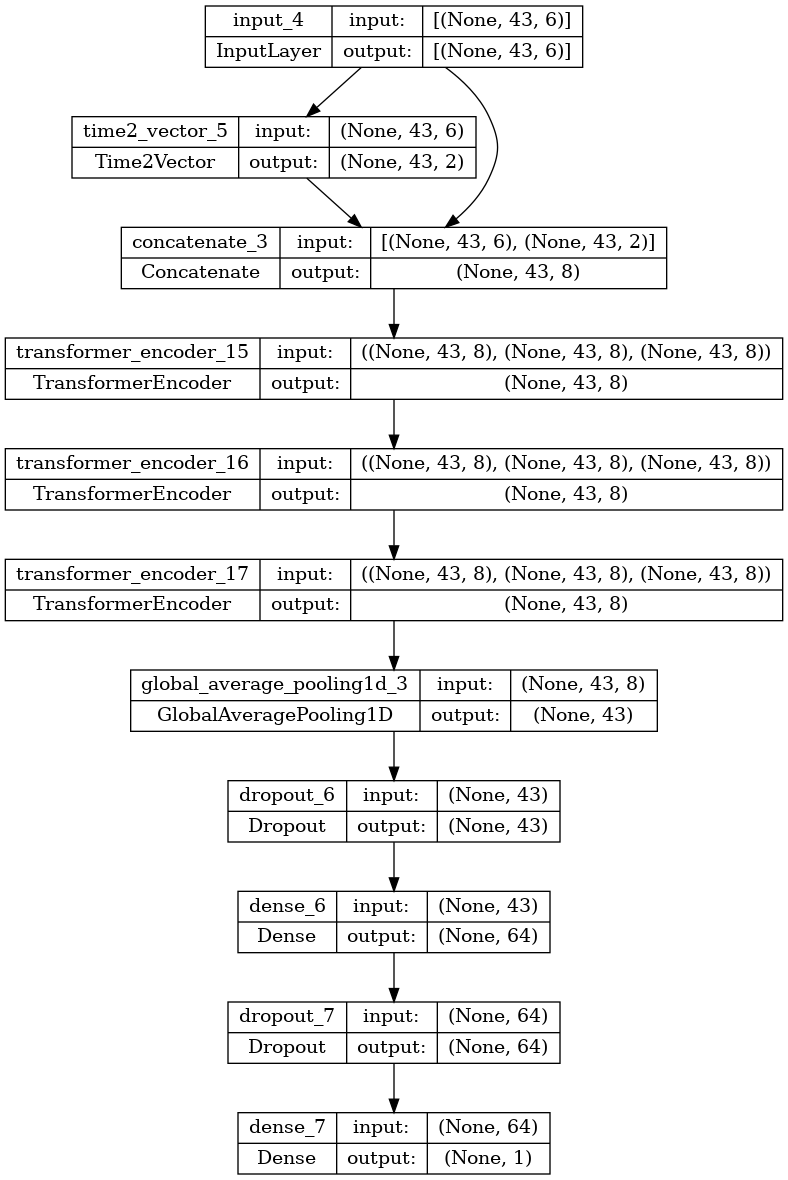

In [47]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

# Moving Average

## Moving Average - Load data again, to apply rolling window

In [48]:
df = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)


# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# the max close price in next 19 days
df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
# the close price after 10 days
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

# Close price is less than the max close price after 19 days
df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

# Result should be a predict number, 1 means the price trend is increase 
# (the max close and close within next 10 days is higher then current price)

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,date,open,high,low,close,volume,Result
9,2017-01-26,17.031,17.435,16.855,17.252,41475.5,1
10,2017-02-03,18.235,18.646,17.898,18.354,51864.5,1
11,2017-02-06,19.247,19.792,18.883,19.475,62548.9,1
12,2017-02-07,20.244,21.025,19.808,20.708,79394.2,1
13,2017-02-08,21.283,22.381,20.825,22.064,88723.7,1


## Moving Average - Plot daily closing prices and volume

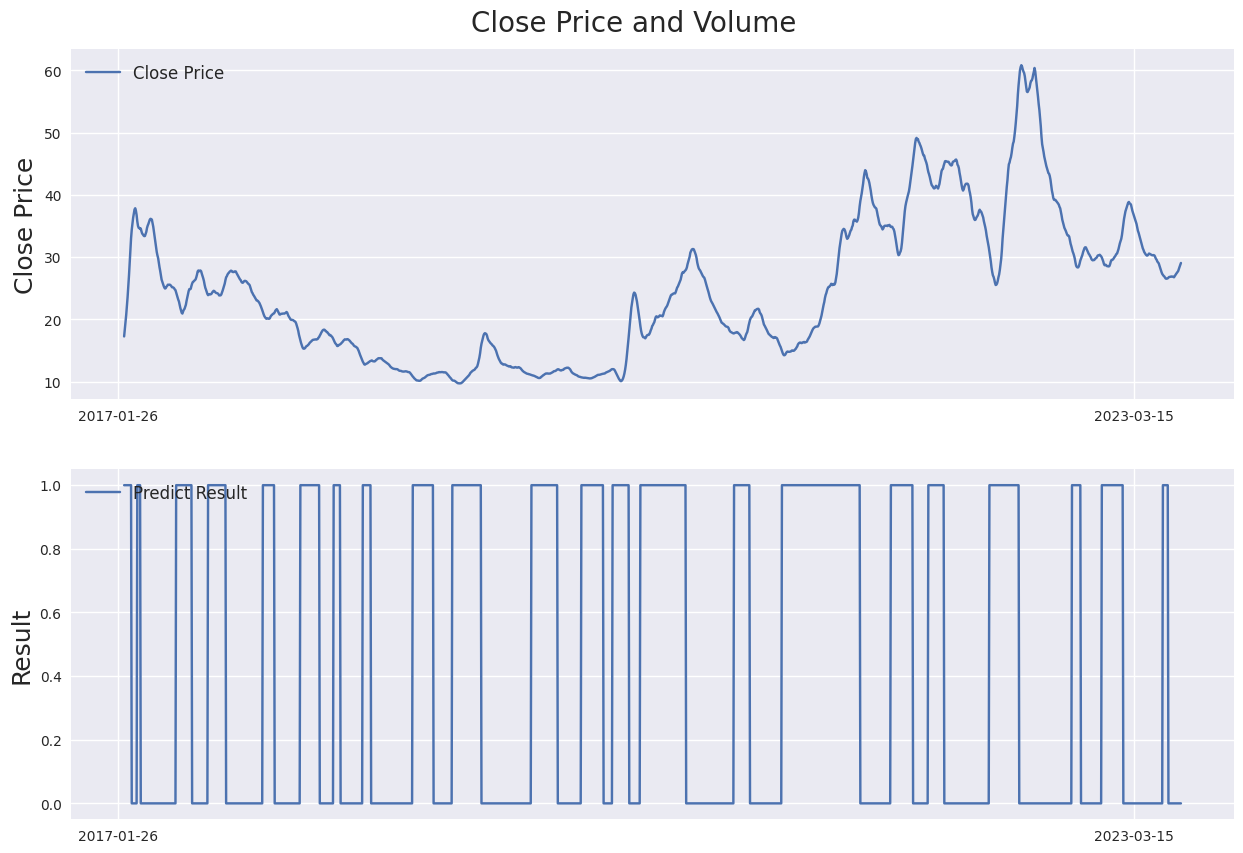

In [49]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [50]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
#Why min max is based on index < 20 pct? Why Not based on all?
min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
#It seams if result is either 0 or 1, then it does not need normalize
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]

if train_from_scratch:
    #if train_from_scratch is True, then use the only last 10 pct for predict
    df_test = df[(df.index >= last_10pct)]
    df_test_with_date = df[(df.index >= last_10pct)]
else: 
    #if train_from_scratch is False, then I could like to use all the df data for predict
    df_test = df[(df.index >= 0)]
    df_test_with_date = df[(df.index >= 0)]

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (1219, 6)
Validation data shape: (152, 6)
Test data shape: (1523, 6)


,open,high,low,close,volume,Result
10,0.874279,0.865019,0.808282,0.823227,0.253561,1.0
11,0.760486,0.805138,0.757015,0.802260,0.233738,1.0
12,0.732800,0.811405,0.711726,0.818998,0.261952,1.0
13,0.729233,0.827854,0.729376,0.835247,0.194297,1.0
14,0.869848,0.844096,0.881393,0.851268,0.148696,1.0


## Moving Average - Plot daily changes of close price and volume

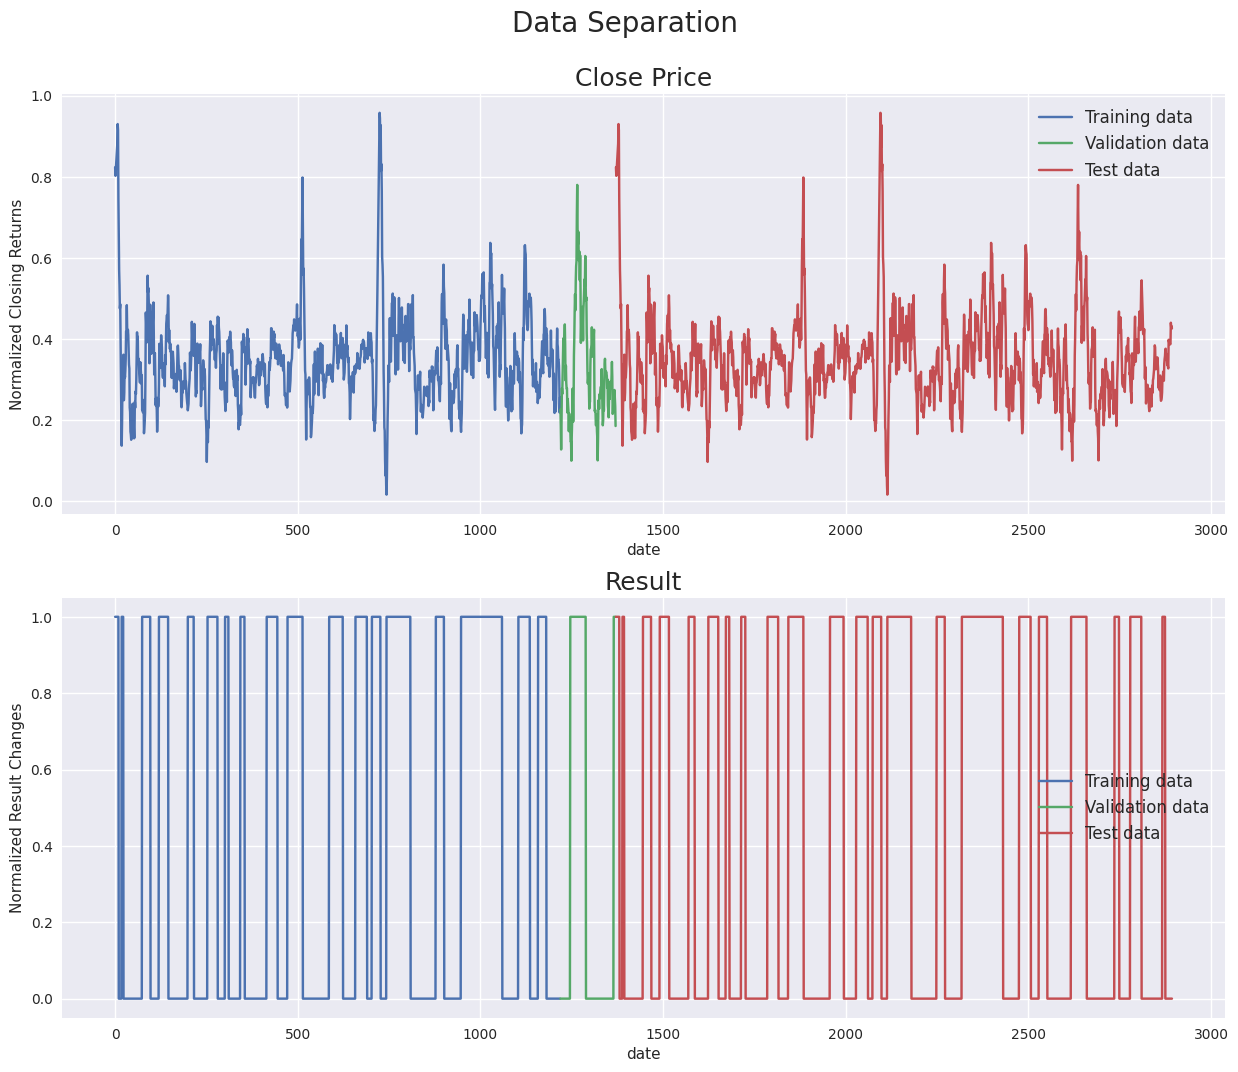

In [51]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Result'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Result'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Result'], label='Test data')
ax2.set_xlabel('date')
ax2.set_ylabel('Normalized Result Changes')
ax2.set_title("Result", fontsize=18)
ax2.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Create chunks of training, validation, and test data

In [52]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
#print(X_test_with_date_last_43.shape)
#print(X_test_with_date_last_43)

(1176, 43, 6) (1176,)
(109, 43, 6) (109,)
(1480, 43, 6) (1480,)


## Moving Average - Model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 43, 6)]      0           []                               
                                                                                                  
 time2_vector_6 (Time2Vector)   (None, 43, 2)        172         ['input_5[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 43, 8)        0           ['input_5[0][0]',                
                                                                  'time2_vector_6[0][0]']         
                                                                                                  
 transformer_encoder_18 (Transf  (None, 43, 8)       111920      ['concatenate_4[0][0]',    

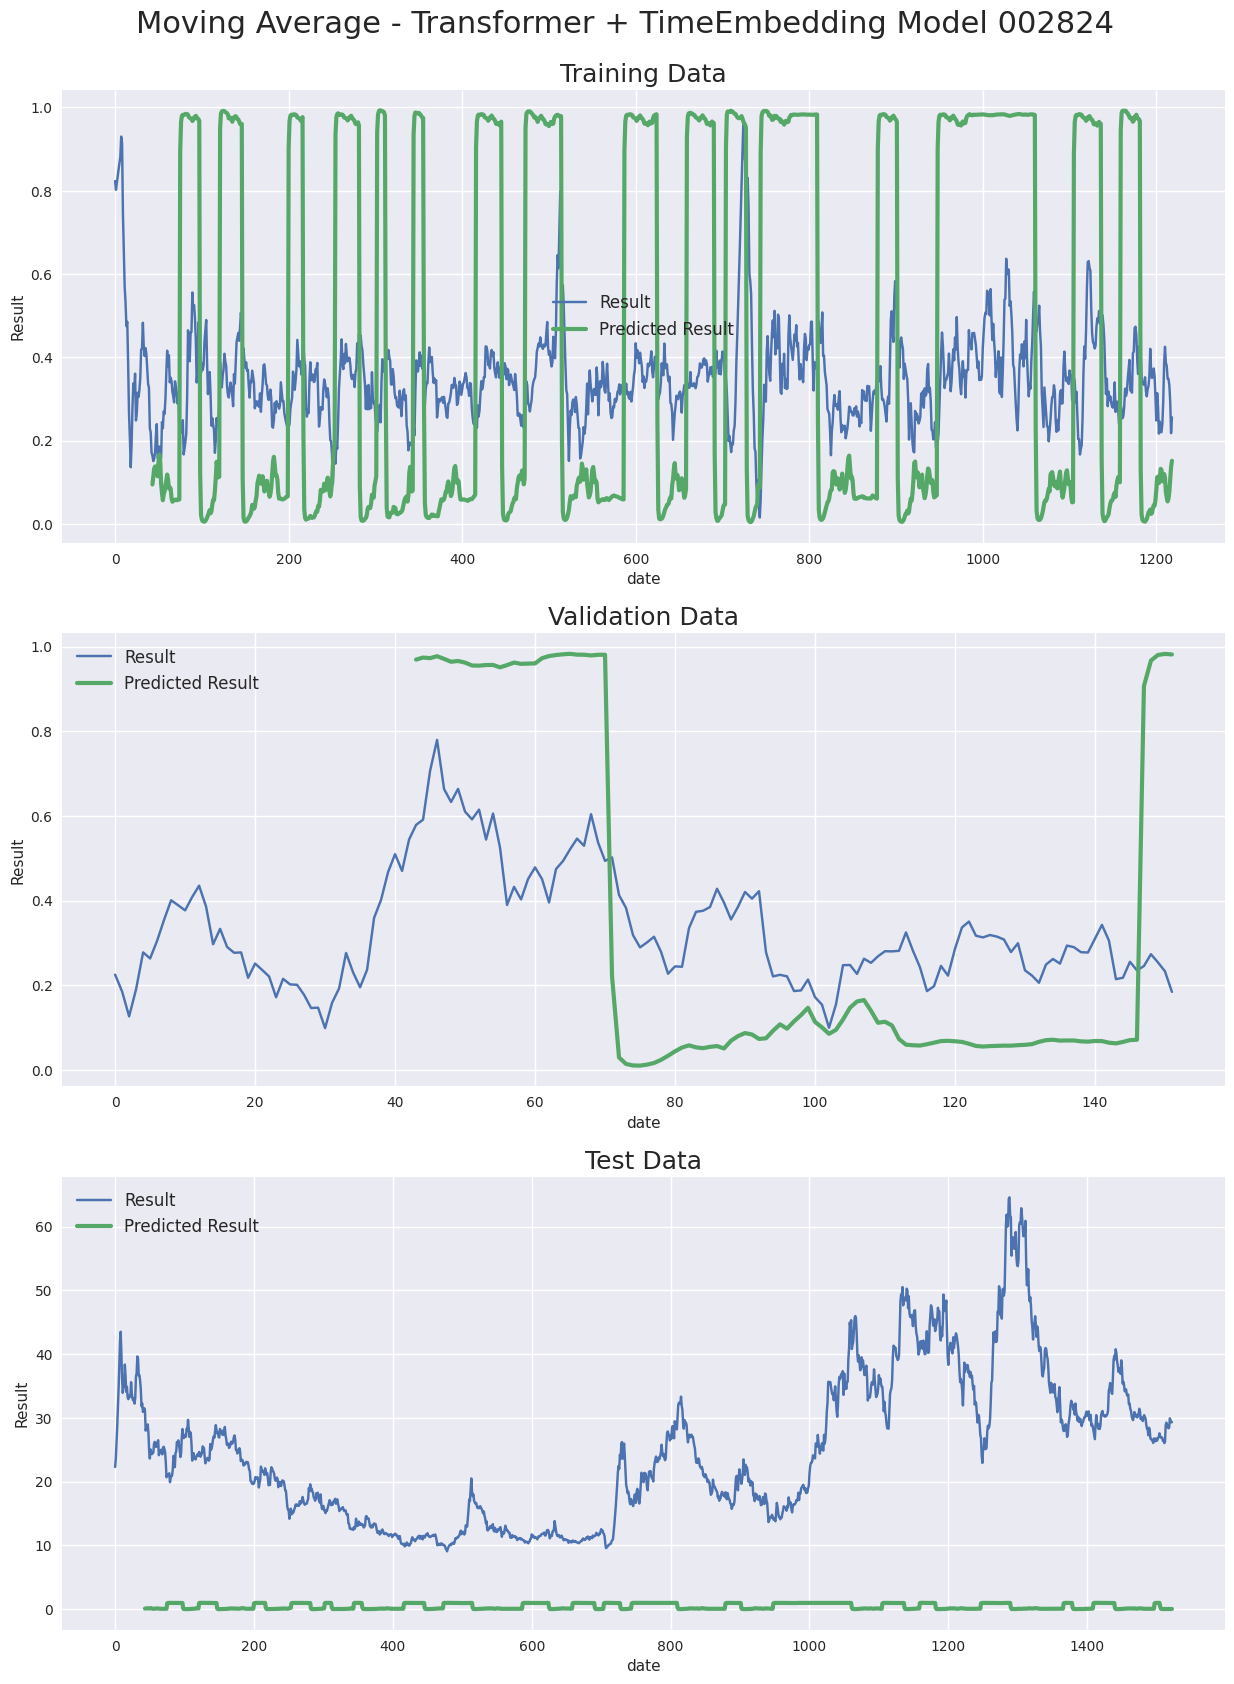

In [53]:
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, column_len))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  #out = Dense(1, activation='linear')(x)
  out = Dense(1, activation='sigmoid')(x) #predict 1 or 0

  model = Model(inputs=in_seq, outputs=out)
  #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])#linear use mse
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mape'])#sigmoid use binary_crossentropy
  return model


model = create_model()
model.summary()

ckp = './checkpoints/Transformer+TimeEmbedding_mean_' + stock_id + '.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(ckp, 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

if train_from_scratch:
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
else:
    if use_checkpoints_id != None:
        ckp = './checkpoints/Transformer+TimeEmbedding_mean_' + use_checkpoints_id + '.hdf5'
        
    model = tf.keras.models.load_model(ckp,
                                       custom_objects={'Time2Vector': Time2Vector, 
                                                       'SingleAttention': SingleAttention,
                                                       'MultiAttention': MultiAttention,
                                                       'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_price_path, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values
df2_close_price = df2_close[-len(test_data):]

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model " + stock_id, fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Result')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Result')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('date')
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Result')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Result')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('date')
ax21.set_ylabel('Result')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
#ax31.plot(test_data[:, 3], label='Result')
ax31.plot(df2_close_price, label='Result')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Result')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('date')
ax31.set_ylabel('Result')
ax31.legend(loc="best", fontsize=12)
plt.show()

## Moving Average - Model metrics

In [54]:
'''Display model metrics'''
if train_from_scratch:
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
    st.set_y(0.92)

    #Plot model loss
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean average error (MAE)')
    ax2.legend(loc="best", fontsize=12)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean average percentage error (MAPE)')
    ax3.legend(loc="best", fontsize=12)
    plt.show()

In [55]:
#5. Analysis for the result (in progress)

#Because the prediction is calculated by Moving average and then normalziation, so we are trying to return the difference to the real world. \

#Here, we calculate the difference between real case and prediction, and compared with the real result.


In [56]:
print(X_test.shape, y_test.shape)
test_pred = model.predict(X_test)

print('len of test_pred:', len(test_pred))
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]
print('len of df_test_with_date:', len(df_test_with_date))

print('last 60 of test_pred:',test_pred[-60:])
print('last 60 of df_test_with_date:',df_test_with_date['date'][-60:])

#for pred in test_pred:
#    print(pred)
#for date in df_test_with_date['date'].values:
#    print(date)

(1480, 43, 6) (1480,)
47/47 [==============================] - 3s 72ms/step
len of test_pred: 1480
len of df_test_with_date: 1480
last 60 of test_pred: [[0.12131441]
 [0.11062427]
 [0.08850915]
 [0.10221648]
 [0.11275735]
 [0.126696  ]
 [0.0931168 ]
 [0.08157729]
 [0.06641094]
 [0.07173304]
 [0.08575314]
 [0.11646856]
 [0.1355052 ]
 [0.13464144]
 [0.10934145]
 [0.09142753]
 [0.09765257]
 [0.0923864 ]
 [0.06573856]
 [0.05383702]
 [0.05436374]
 [0.05437586]
 [0.05494451]
 [0.05767962]
 [0.05991539]
 [0.06045599]
 [0.06139448]
 [0.06367653]
 [0.06337952]
 [0.06486499]
 [0.06702859]
 [0.06845494]
 [0.06901503]
 [0.06846063]
 [0.9065297 ]
 [0.9671304 ]
 [0.9803954 ]
 [0.98283374]
 [0.98165864]
 [0.98259926]
 [0.98405933]
 [0.9837896 ]
 [0.43228123]
 [0.08305617]
 [0.0270881 ]
 [0.01768013]
 [0.01964687]
 [0.02210612]
 [0.02218591]
 [0.02675771]
 [0.02794942]
 [0.02853321]
 [0.02889491]
 [0.03191329]
 [0.02450186]
 [0.0260206 ]
 [0.02272831]
 [0.02599864]
 [0.02505061]
 [0.03178053]]
last 60

In [57]:
#Save AI predict to DB
import psycopg2
import numpy
from psycopg2.extensions import register_adapter, AsIs
def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)
def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)
def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)
register_adapter(numpy.float32, addapt_numpy_float32)
register_adapter(numpy.float64, addapt_numpy_float64)
register_adapter(numpy.int64, addapt_numpy_int64)


#Establishing the connection
conn = psycopg2.connect(
   database="easystogu", user='postgres', password='postgres', host='192.168.10.200', port= '5432'
)
#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#First delete then insert
index=0
for date in df_test_with_date['date'].values:
    result=test_pred[index][0]
    cursor.execute("delete from AI_TREND_PREDICTION where stockid=%s and date=%s", (stock_id,date))
    cursor.execute("insert into AI_TREND_PREDICTION (stockid,date,result) values(%s, %s, %s)", (stock_id, date, result))
    index+=1

# Commit your changes in the database
conn.commit()

# Closing the connection
conn.close()